In [7]:
# %% 0) Setup & config
import os, json, glob, random
from pathlib import Path
from collections import defaultdict
from typing import Dict, Tuple
import numpy as np
from PIL import Image, ImageOps

# ---- choose projection and paths
PROJECTION = "max_projection"   # or "mean_projection"
MIP_MODE   = (PROJECTION == "max_projection")

REPO      = Path("borg-main")
DATA_ROOT = REPO / "data" / PROJECTION
TRAIN_JSON = DATA_ROOT / "organoid_coco_train.json"
VAL_JSON   = DATA_ROOT / "organoid_coco_val.json"
TRAIN_DIR  = DATA_ROOT / "images" / "train"
VAL_DIR    = DATA_ROOT / "images" / "val"

# ---- outputs
IMG_SIZE = 96
PATCH_CACHE_TRAIN = Path("patch_cache_train")
MASKS_DIR         = Path("processed_masks_train")
PATCH_CACHE_TRAIN.mkdir(exist_ok=True)
MASKS_DIR.mkdir(exist_ok=True)

CLASSES = ["Prophase","Metaphase","Anaphase","Telophase"]
for c in CLASSES:
    (PATCH_CACHE_TRAIN/c).mkdir(parents=True, exist_ok=True)
    (MASKS_DIR/c).mkdir(parents=True, exist_ok=True)

print("Using:", DATA_ROOT.resolve())


Using: /home/sebas_dev_linux/projects/snn_project/Diffusion_SNN_ML_v0/borg-main/data/max_projection


In [8]:
# %% 1) Load COCO and resolve paths
with open(TRAIN_JSON, "r") as f: train_coco = json.load(f)
with open(VAL_JSON,   "r") as f: val_coco   = json.load(f)

categories_map: Dict[int,str] = {c["id"]: c["name"] for c in train_coco["categories"]}
id2file_train = {im["id"]: im["file_name"] for im in train_coco["images"]}

train_anns = train_coco["annotations"]

def resolve_image_path(file_name: str) -> Path|None:
    p = Path(file_name)
    cands = [p, DATA_ROOT/p, TRAIN_DIR/p.name, TRAIN_DIR/p]
    for c in cands:
        if c.exists():
            return c
    return None

print("Categories:", categories_map)
print("Train anns:", len(train_anns))
# COCO JSON spec refs. :contentReference[oaicite:2]{index=2}


Categories: {1: 'Prophase', 2: 'Metaphase', 3: 'Anaphase', 4: 'Telophase'}
Train anns: 556


In [9]:
# %% 2) Preprocess helpers (flat-field, ring suppression, letterbox)
from skimage.morphology import white_tophat, opening, disk as sk_disk
from skimage.exposure import rescale_intensity

def percentile_clip_u8(arr_u8, p=99.5):
    hi = np.percentile(arr_u8, p)
    arr = np.clip(arr_u8.astype(np.float32), 0, hi) / (hi + 1e-6)
    return (arr * 255).astype(np.uint8)

def rolling_shading_correction_rgb(im, rad_px=27):
    arr = np.asarray(im).astype(np.uint8)
    se = sk_disk(rad_px)
    out = np.empty_like(arr)
    for c in range(3):
        out[...,c] = white_tophat(arr[...,c], footprint=se)
        out[...,c] = rescale_intensity(out[...,c], in_range='image', out_range=(0,255)).astype(np.uint8)
    return Image.fromarray(out, "RGB")

def suppress_green_ring(im, ring_rad=13):
    arr = np.asarray(im).astype(np.uint8)
    G = arr[...,1]
    G_bg   = opening(G, sk_disk(ring_rad))
    G_supp = np.clip(G.astype(np.int16) - G_bg.astype(np.int16), 0, 255).astype(np.uint8)
    arr[...,1] = G_supp
    return Image.fromarray(arr, "RGB")

def letterbox(im: Image.Image, size=96, bg=(0,0,0)):
    w,h = im.size
    s = min(size/w, size/h)
    nw, nh = int(round(w*s)), int(round(h*s))
    canvas = Image.new("RGB", (size,size), bg)
    canvas.paste(im.resize((nw,nh), Image.Resampling.LANCZOS),
                 ((size-nw)//2, (size-nh)//2))
    return canvas
# Morphology basics refs. :contentReference[oaicite:3]{index=3}


In [10]:
# %% 3) Cache 96x96 train patches (COCO bboxes + padding + preprocessing)
PAD_FRAC = {"Prophase":0.25, "Metaphase":0.25, "Anaphase":0.35, "Telophase":0.35}

ann_to_patch = {}
class_to_ann = defaultdict(list)
miss, bad = 0, 0

for ann in train_anns:
    cls = categories_map[ann["category_id"]]
    file_name = id2file_train.get(ann["image_id"])
    src = resolve_image_path(file_name) if file_name else None
    if src is None:
        miss += 1; continue
    x,y,w,h = map(float, ann.get("bbox", [0,0,0,0]))
    if w<=1 or h<=1: bad += 1; continue

    img = Image.open(src).convert("RGB")
    img = suppress_green_ring(rolling_shading_correction_rgb(img), ring_rad=13)

    pad = PAD_FRAC.get(cls, 0.30)
    x0 = max(0, int(round(x - pad*w))); y0 = max(0, int(round(y - pad*h)))
    x1 = min(img.width,  int(round(x + w + pad*w)))
    y1 = min(img.height, int(round(y + h + pad*h)))
    if x1<=x0 or y1<=y0: bad += 1; continue

    crop = img.crop((x0,y0,x1,y1))
    patch = letterbox(crop, IMG_SIZE)
    if MIP_MODE:  # gentle clip + despeckle for MIPs
        arr = np.asarray(patch).astype(np.uint8)
        for c in range(3): arr[...,c] = percentile_clip_u8(arr[...,c], p=99.5)
        patch = Image.fromarray(arr, "RGB")

    outp = PATCH_CACHE_TRAIN/cls/f"patch_{ann['id']}.png"
    patch.save(outp)
    ann_to_patch[ann["id"]] = str(outp)
    class_to_ann[cls].append(ann["id"])

print("Cached:", len(ann_to_patch), "| missing:", miss, "| bad bbox:", bad)


/tmp/ipykernel_13645/2101119721.py:17: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(out, "RGB")
/tmp/ipykernel_13645/2101119721.py:25: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, "RGB")
/tmp/ipykernel_13645/2482873512.py:31: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  patch = Image.fromarray(arr, "RGB")


Cached: 556 | missing: 0 | bad bbox: 0


In [45]:
# %% 4) Build masks (denoise+bg-fix → smooth R/(R+G)+Otsu+hysteresis → class-aware tweaks → watershed)

import numpy as np
from PIL import Image

from skimage.filters import (
    threshold_local, apply_hysteresis_threshold, gaussian,
    threshold_otsu, threshold_sauvola
)
from skimage.morphology import (
    remove_small_holes, remove_small_objects, binary_opening, binary_closing,
    white_tophat, disk as sk_disk, h_minima
)
from skimage.segmentation import watershed, chan_vese
from skimage.measure import label
from skimage.exposure import equalize_adapthist
from skimage.restoration import denoise_nl_means, estimate_sigma, rolling_ball
from skimage.feature import canny, peak_local_max
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import disk as draw_disk
from scipy.ndimage import distance_transform_edt
from skimage.transform import warp_polar  # robust center→radial profile
from skimage.measure import regionprops
from skimage.filters import sobel
from skimage.morphology import h_maxima


# ── params (tunable) ────────────────────────────────────────────────────────────
TOPHAT_RAD     = 7
MIN_SIZE_NUC   = 120
MIN_SIZE_CYT   = 250
HOLE_SIZE      = 180
BORDER_PX      = 4
CROSSTALK_ALPHA= 0.20
CLAHE_CLIP     = 0.02
CLAHE_TILE     = 12
RB_RADIUS      = 24            # stronger rolling-ball to flatten G halo
LOC_BLOCK      = 19            # window for Sauvola/local ops
SAUV_K         = 0.20
GAUSS_SIGMA    = 0.8
HMIN           = 1.0

# ── preprocessing ───────────────────────────────────────────────────────────────
def preproc_rgb(rgb_u8):
    """Denoise + local contrast normalize + green background subtraction."""
    rgb = rgb_u8.astype(np.float32) / 255.0
    sigma_est = np.mean(estimate_sigma(rgb, channel_axis=-1))
    den = denoise_nl_means(rgb, h=1.15*sigma_est, patch_size=5, patch_distance=6,
                           fast_mode=True, channel_axis=-1, preserve_range=True)
    den = (np.clip(den, 0, 1) * 255).astype(np.uint8)

    R = (equalize_adapthist(den[..., 0], clip_limit=CLAHE_CLIP, kernel_size=CLAHE_TILE)*255).astype(np.uint8)
    G = (equalize_adapthist(den[..., 1], clip_limit=CLAHE_CLIP, kernel_size=CLAHE_TILE)*255).astype(np.uint8)
    B = den[..., 2]

    # Rolling-ball background on G, then subtract background
    bg = rolling_ball(G, radius=RB_RADIUS)
    G = (G.astype(np.float32) - bg).clip(0, 255).astype(np.uint8)
    return np.stack([R, G, B], axis=-1)

# ── ratio index on smoothed channels ────────────────────────────────────────────
def index_rg_smooth(Ru8, Gu8):
    Rf = gaussian(Ru8.astype(np.float32)/255.0, GAUSS_SIGMA)
    Gf = gaussian(Gu8.astype(np.float32)/255.0, GAUSS_SIGMA)
    Rf = np.clip(Rf - CROSSTALK_ALPHA*Gf, 0.0, 1.0)
    idx = Rf / (Rf + Gf + 1e-6)
    return idx.astype(np.float32)  # 0..1

# ── nucleus cleanup with watershed keep-largest ────────────────────────────────
def watershed_keep_largest(nuc_bw):
    if nuc_bw.sum() == 0:
        return nuc_bw
    dist = distance_transform_edt(nuc_bw)
    # suppress tiny peaks, then use maxima as markers
    markers = label(h_maxima(dist, HMIN))
    if markers.max() == 0:
        return nuc_bw
    ws = watershed(-dist, markers, mask=nuc_bw)
    labs, sizes = np.unique(ws, return_counts=True)
    if len(labs) <= 1:
        return nuc_bw
    keep = labs[1:][np.argmax(sizes[1:])]
    return (ws == keep)

# ── adaptive cyto ring around nucleus ──────────────────────────────────────────
def cyto_ring_adaptive(nuc_bw, rin_frac=0.25, rout_frac=0.60):
    if nuc_bw.sum() == 0:
        return np.zeros_like(nuc_bw, bool)
    area = float(nuc_bw.sum())
    r_eq = np.sqrt(area / np.pi)
    rmin = max(3, int(round(rin_frac  * r_eq)))
    rmax = max(rmin+2, int(round(rout_frac * r_eq)))
    dist_out = distance_transform_edt(~nuc_bw)
    return (dist_out >= rmin) & (dist_out <= rmax)

# ── Metaphase: detect ring (Hough) + region refinement (Chan–Vese) ─────────────

def ring_from_radial_profile(Gcorr, nuc_seed, rmin=10, rmax=None, band_frac=0.18,
                             min_prom=5.0, grad_weight=0.6):
    """
    Edge-aware ring finder:
    - Blend intensity and gradient radial profiles in polar space.
    - Return (cx, cy, R, band) or None if confidence low.
    """
    if rmax is None:
        rmax = min(Gcorr.shape)//2 - 2

    # nucleus centroid → initial center (fallback to image center)
    props = regionprops(nuc_seed.astype(np.uint8))
    if props:
        cy, cx = props[0].centroid
    else:
        cy, cx = (Gcorr.shape[0]-1)/2.0, (Gcorr.shape[1]-1)/2.0
    cy, cx = float(cy), float(cx)

    # intensity & gradient in polar
    polar_I = warp_polar(Gcorr, center=(cx, cy), radius=rmax,
                         output_shape=(360, rmax), scaling='linear', preserve_range=True)
    Gg = sobel(Gcorr)
    polar_G = warp_polar(Gg, center=(cx, cy), radius=rmax,
                         output_shape=(360, rmax), scaling='linear', preserve_range=True)

    radial_I = polar_I.mean(axis=0)
    radial_G = polar_G.mean(axis=0)

    # blend: emphasize edges but keep intensity cue
    radial = (1.0 - grad_weight)*radial_I + grad_weight*radial_G

    r0 = max(3, int(rmin)); r1 = min(rmax-1, len(radial)-1)
    prof = radial[r0:r1]

    peak_idx = int(np.argmax(prof)); peak_val = float(prof[peak_idx])
    base = float(np.median(prof))
    prom = peak_val - base
    if prom < min_prom:
        return None

    R = r0 + peak_idx
    band = max(2, int(round(band_frac * R)))
    return int(round(cx)), int(round(cy)), int(R), int(band)

def ring_angular_coverage(Gcorr, cx, cy, R, r_width=2, rel_thr=0.35):
    # Edge map in a thin annulus
    Gg = sobel(Gcorr)
    H, W = Gg.shape
    Y, X = np.ogrid[:H, :W]
    d = np.sqrt((X - cx)**2 + (Y - cy)**2)
    ann = (d >= R - r_width) & (d <= R + r_width)
    # unwrap and compute per-angle energy
    polar = warp_polar(Gg, center=(cx, cy), radius=R + r_width,
                       output_shape=(360, R + r_width), scaling='linear', preserve_range=True)
    edge_per_angle = polar[:, max(1, R - r_width): R + r_width + 1].mean(axis=1)
    thr = edge_per_angle.max() * rel_thr
    covered = (edge_per_angle >= thr).mean()  # in [0,1]
    return float(covered)



def metaphase_nucleus_radial(idx, Gcorr, nuc_seed):
    det = ring_from_radial_profile(Gcorr, nuc_seed, rmin=10, band_frac=0.20, min_prom=5.0)
    if det is None:
        thr = threshold_otsu(idx); hi, lo = min(1.,thr+0.06), max(0.,thr-0.06)
        return apply_hysteresis_threshold(idx, lo, hi), None

    cx, cy, R, band = det  # ← unpack first
    cov = ring_angular_coverage(Gcorr, cx, cy, R, r_width=max(2, band//2), rel_thr=0.35)
    if cov < 0.45:
        thr = threshold_otsu(idx); hi, lo = min(1.,thr+0.06), max(0.,thr-0.06)
        return apply_hysteresis_threshold(idx, lo, hi), None

    H, W = idx.shape
    Y, X = np.ogrid[:H, :W]
    d = np.sqrt((X - cx)**2 + (Y - cy)**2)

    roi = d <= max(3, R - band - 1)
    init_thr = threshold_otsu(idx[roi])
    init = (idx > init_thr) & roi

    cv_mask = chan_vese(idx, mu=0.0, lambda1=1, lambda2=1, tol=1e-3,
                        max_num_iter=80, dt=0.5, init_level_set=init, extended_output=False)
    nuc = cv_mask & roi
    return nuc, (cx, cy, R, band)

def metaphase_cyto_radial(Gcorr, det):
    """
    Build the cytoplasmic ring as an annulus around the detected ring.
    Uses Sauvola inside the annulus for robustness to background.
    """
    if det is None:
        th = threshold_sauvola(Gcorr, window_size=LOC_BLOCK, k=SAUV_K)
        cytraw = (Gcorr > th)
        return cytraw  # will be intersected with adaptive ring later

    cx, cy, R, band = det
    H, W = Gcorr.shape
    Y, X = np.ogrid[:H, :W]
    d = np.sqrt((X - cx)**2 + (Y - cy)**2)

    inner = max(1, R - band)
    outer = min(R + int(1.2*band), max(H, W))
    ring_mask = (d >= inner) & (d <= outer)

    th = threshold_sauvola(Gcorr, window_size=LOC_BLOCK, k=SAUV_K)
    cyto = (Gcorr > th) & ring_mask
    cyto = remove_small_objects(cyto, MIN_SIZE_CYT)
    cyto = remove_small_holes(cyto, area_threshold=MIN_SIZE_CYT//2)
    return cyto

# ── Anaphase: split two lobes with dual markers ────────────────────────────────
def split_anaphase_lobes(nuc_init, min_dist=6):
    if nuc_init.sum() == 0:
        return nuc_init
    dist = distance_transform_edt(nuc_init)
    coords = peak_local_max(dist, min_distance=min_dist, labels=nuc_init, num_peaks=2)
    markers = np.zeros_like(nuc_init, dtype=np.int32)
    for i, (r, c) in enumerate(coords[:2], start=1):
        markers[r, c] = i
    if markers.max() < 2:
        return nuc_init
    ws = watershed(-dist, markers=markers, mask=nuc_init)
    labs, sizes = np.unique(ws, return_counts=True)
    order = np.argsort(sizes[1:])[::-1]
    keep_ids = [labs[1:][order[0]]] + ([labs[1:][order[1]]] if len(order) > 1 else [])
    return np.isin(ws, keep_ids)

# ── main loop ──────────────────────────────────────────────────────────────────
qc_rows = []
for cls, ann_ids in class_to_ann.items():
    for ann_id in ann_ids:
        pth = ann_to_patch[ann_id]
        rgb = np.asarray(Image.open(pth).convert("RGB")).astype(np.uint8)

        rgbp = preproc_rgb(rgb)
        R, G = rgbp[..., 0], rgbp[..., 1]

        # ratio + Otsu-anchored hysteresis (default)
        idx = index_rg_smooth(R, G)
        thr = threshold_otsu(idx)
        hi, lo = min(1.0, thr + 0.06), max(0.0, thr - 0.06)
        nuc_default = apply_hysteresis_threshold(idx, lo, hi)

        if cls == "Metaphase":
            # seed nucleus from default hysteresis on ratio
            nuc_seed = remove_small_objects(nuc_default, max(40, MIN_SIZE_NUC//2))
            nuc, det = metaphase_nucleus_radial(idx, G, nuc_seed)
            nuc = remove_small_objects(nuc, MIN_SIZE_NUC)
            nuc = remove_small_holes(nuc, HOLE_SIZE)
            nuc = watershed_keep_largest(nuc)

            cytraw = metaphase_cyto_radial(G, det)
            ring = cyto_ring_adaptive(nuc) if det is None else np.ones_like(nuc, bool)
            cyt = cytraw & ring
            cyt = remove_small_objects(cyt, MIN_SIZE_CYT)
            cyt = remove_small_holes(cyt, area_threshold=MIN_SIZE_CYT//2)

        elif cls == "Anaphase":
            nuc = remove_small_objects(nuc_default, MIN_SIZE_NUC)
            nuc = split_anaphase_lobes(nuc, min_dist=6)
            nuc = watershed_keep_largest(nuc)
            th_map = threshold_sauvola(G, window_size=LOC_BLOCK, k=SAUV_K)
            cytraw = (G > th_map)
            ring = cyto_ring_adaptive(nuc)
            cyt = cytraw & ring
            cyt = remove_small_objects(cyt, MIN_SIZE_CYT)
            cyt = remove_small_holes(cyt, area_threshold=MIN_SIZE_CYT//2)

        else:  # Prophase, Telophase (current default works well)
            nuc = remove_small_objects(nuc_default, MIN_SIZE_NUC)
            nuc = remove_small_holes(nuc, HOLE_SIZE)
            nuc = binary_opening(binary_closing(nuc))
            nuc = watershed_keep_largest(nuc)
            th_map = threshold_sauvola(G, window_size=LOC_BLOCK, k=SAUV_K)
            cytraw = (G > th_map)
            ring = cyto_ring_adaptive(nuc)
            cyt = cytraw & ring
            cyt = remove_small_objects(cyt, MIN_SIZE_CYT)
            cyt = remove_small_holes(cyt, area_threshold=MIN_SIZE_CYT//2)

        # save masks
        Image.fromarray((nuc | cyt).astype(np.uint8) * 255).save(MASKS_DIR / cls / f"mask_{ann_id}.png")
        seg = np.zeros_like(rgb); seg[..., 0] = nuc.astype(np.uint8) * 255; seg[..., 1] = cyt.astype(np.uint8) * 255
        Image.fromarray(seg).save(MASKS_DIR / cls / f"seg_{ann_id}.png")

        # QC metrics
        b = BORDER_PX
        border = np.zeros_like(nuc, bool); border[:b,:]=border[-b:,:]=border[:,:b]=border[:,-b:]=True
        area = float(nuc.mean())
        snr  = float(R[nuc].mean() / (R[~nuc].std() + 1e-6)) if (~nuc).any() else 0.0
        brr  = float((nuc & border).sum()) / (nuc.size + 1e-6)
        qc_rows.append((cls, ann_id, area, snr, brr))


/tmp/ipykernel_13645/3595370165.py:288: RuntimeWarning: Mean of empty slice.
  snr  = float(R[nuc].mean() / (R[~nuc].std() + 1e-6)) if (~nuc).any() else 0.0
/home/sebas_dev_linux/miniconda3/envs/diff/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


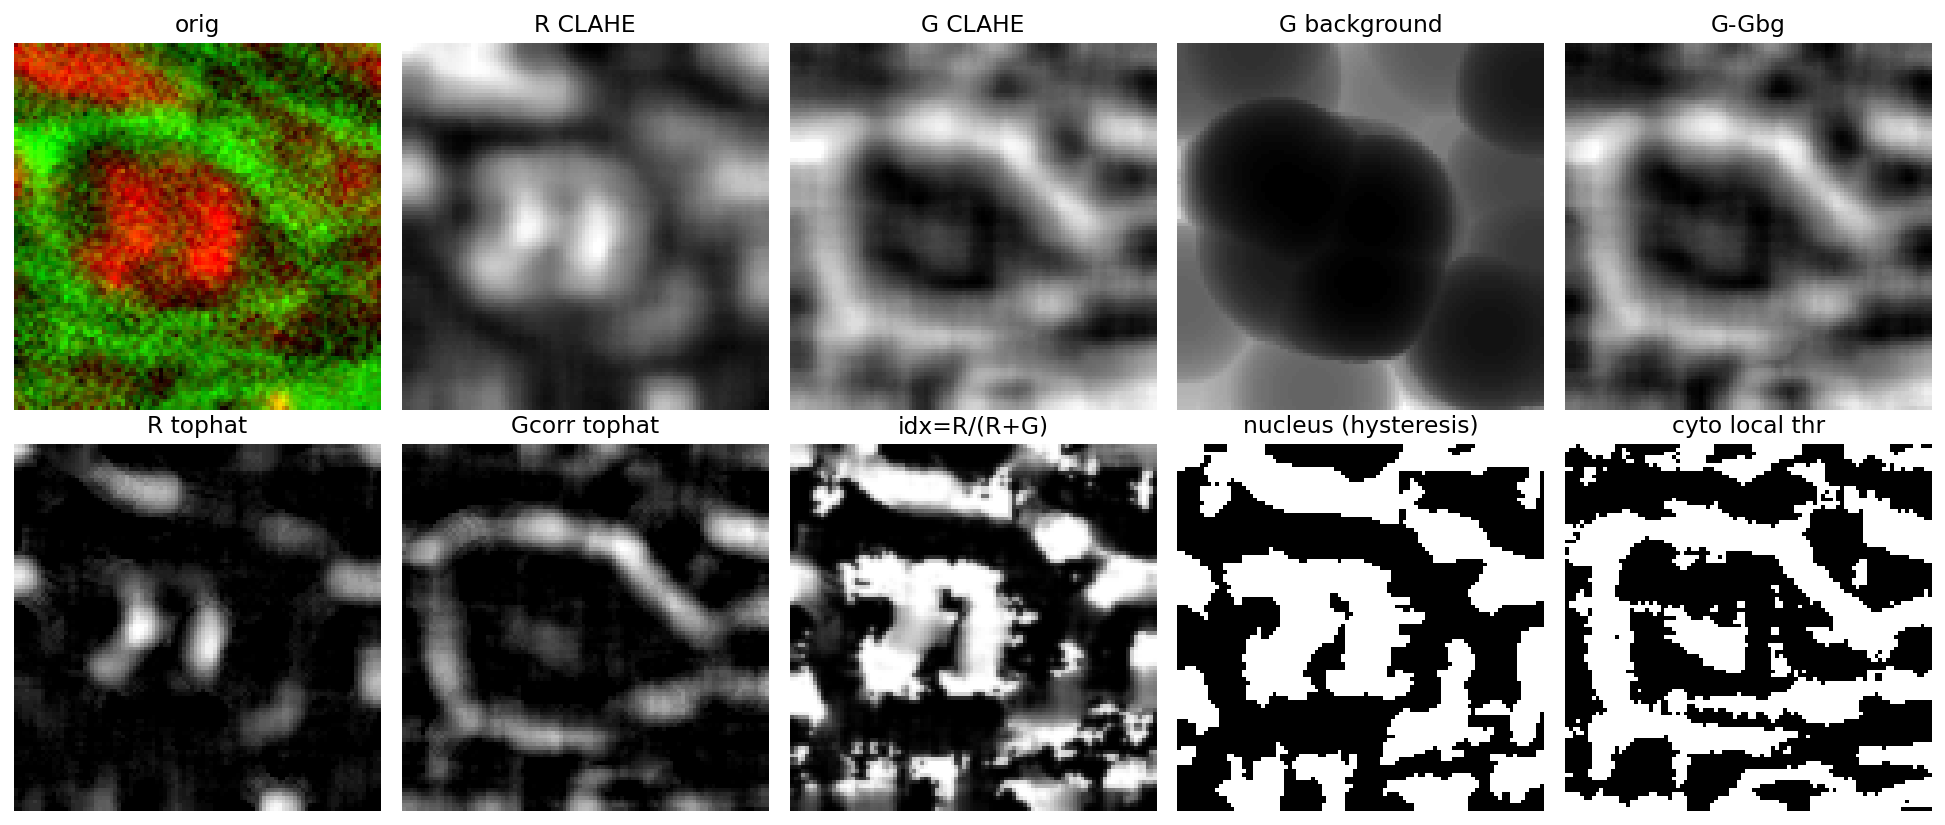

In [46]:
# %% DEBUG PANEL FOR ONE PATCH (intermediates)
import numpy as np, matplotlib.pyplot as plt
from PIL import Image
from skimage.exposure import equalize_adapthist
from skimage.restoration import denoise_nl_means, estimate_sigma, rolling_ball
from skimage.morphology import white_tophat, disk as sk_disk
from skimage.filters import threshold_local, apply_hysteresis_threshold, gaussian

ANN = list(ann_to_patch.keys())[0]  # pick one, e.g., 73 or 533
RGB = np.asarray(Image.open(ann_to_patch[ANN]).convert("RGB")).astype(np.uint8)

def preproc(rgb, clahe_clip=0.02, clahe_tile=12, rb_radius=20):
    f = rgb.astype(np.float32)/255.0
    sig = np.mean(estimate_sigma(f, channel_axis=-1))
    den = denoise_nl_means(f, h=1.15*sig, patch_size=5, patch_distance=6,
                           fast_mode=True, channel_axis=-1, preserve_range=True)
    den = (np.clip(den,0,1)*255).astype(np.uint8)
    R = (equalize_adapthist(den[...,0], clip_limit=clahe_clip, kernel_size=clahe_tile)*255).astype(np.uint8)
    G = (equalize_adapthist(den[...,1], clip_limit=clahe_clip, kernel_size=clahe_tile)*255).astype(np.uint8)
    bg = rolling_ball(G, radius=rb_radius)
    Gcorr = (G.astype(np.float32) - bg).clip(0,255).astype(np.uint8)
    return R, G, bg, Gcorr

R, G, Gbg, Gcorr = preproc(RGB)

Rcorr = white_tophat(R, sk_disk(7))
Gtc   = white_tophat(Gcorr, sk_disk(7))
idx   = Rcorr.astype(np.float32)/(Rcorr.astype(np.float32)+Gtc.astype(np.float32)+1e-6)
idx   = gaussian(idx, 0.6)
hi, lo = np.percentile(idx, 82), np.percentile(idx, 52)
nuc = apply_hysteresis_threshold(idx, lo, hi)
thmap = threshold_local(Gcorr, 19, offset=-1)
cytraw = (Gcorr > thmap)

fig, ax = plt.subplots(2,5, figsize=(14,6), dpi=140)
ax[0,0].imshow(RGB);    ax[0,0].set_title("orig");           ax[0,0].axis("off")
ax[0,1].imshow(R, cmap="gray");     ax[0,1].set_title("R CLAHE"); ax[0,1].axis("off")
ax[0,2].imshow(G, cmap="gray");     ax[0,2].set_title("G CLAHE"); ax[0,2].axis("off")
ax[0,3].imshow(Gbg, cmap="gray");   ax[0,3].set_title("G background"); ax[0,3].axis("off")
ax[0,4].imshow(Gcorr, cmap="gray"); ax[0,4].set_title("G-Gbg");   ax[0,4].axis("off")
ax[1,0].imshow(Rcorr, cmap="gray"); ax[1,0].set_title("R tophat"); ax[1,0].axis("off")
ax[1,1].imshow(Gtc, cmap="gray");   ax[1,1].set_title("Gcorr tophat"); ax[1,1].axis("off")
ax[1,2].imshow(idx, cmap="gray");   ax[1,2].set_title("idx=R/(R+G)"); ax[1,2].axis("off")
ax[1,3].imshow(nuc, cmap="gray");   ax[1,3].set_title("nucleus (hysteresis)"); ax[1,3].axis("off")
ax[1,4].imshow(cytraw, cmap="gray");ax[1,4].set_title("cyto local thr"); ax[1,4].axis("off")
plt.tight_layout(); plt.show()


In [47]:
# %% 5) QC gates, keep/drop, and manifest
AREA_MIN=0.01; SNR_MIN=2.0; BRR_MAX=0.08   # define BEFORE use (order fix)

kept=defaultdict(list); dropped=defaultdict(list)
for cls, ann_id, area, snr, brr in qc_rows:
    ok = (area>=AREA_MIN) and (snr>=SNR_MIN) and (brr<=BRR_MAX)
    (kept if ok else dropped)[cls].append((ann_id, area, snr, brr))

print("Kept per class:", {c:len(v) for c,v in kept.items()})

manifest=[]
for c, rows in kept.items():
    for (ann_id, area, snr, brr) in rows:
        manifest.append(dict(
            _class=c, ann_id=int(ann_id),
            patch_path=ann_to_patch[ann_id],
            mask_path=str(MASKS_DIR/c/f"mask_{ann_id}.png"),
            seg_path=str(MASKS_DIR/c/f"seg_{ann_id}.png"),
            area=float(area), snr=float(snr), border_red=float(brr),
            projection=PROJECTION, mip_mode=bool(MIP_MODE)
        ))

from csv import DictWriter
import json
with open("kept_manifest.json","w") as f: json.dump(manifest, f, indent=2)
with open("kept_manifest.csv","w", newline="") as f:
    w=DictWriter(f, fieldnames=list(manifest[0].keys())); w.writeheader(); w.writerows(manifest)

print("Wrote kept_manifest.json/csv with", len(manifest), "rows.")


Kept per class: {'Prophase': 272, 'Metaphase': 141, 'Anaphase': 67, 'Telophase': 51}
Wrote kept_manifest.json/csv with 531 rows.


In [48]:
# %% Per-class Augmentation Plan (from kept_manifest.csv)

import csv, json, math, os
from collections import defaultdict, Counter

MANIFEST_CSV = "kept_manifest.csv"      # input from your QC pipeline
PLAN_CSV     = "augmentation_plan.csv"  # output: how many augs per sample
WEIGHTS_JSON = "class_weights.json"     # output: sampler / loss weights
SUMMARY_JSON = "plan_summary.json"      # output: quick totals

# --- Strategy knobs ---
STRATEGY = "match_max"   # "match_max" or "target_per_class"
TARGET_PER_CLASS = None  # e.g., {"Prophase": 250, "Metaphase": 250, "Anaphase": 250, "Telophase": 250}
CAP_AUG_PER_SAMPLE = 4   # safety cap (prevents exploding augs for tiny classes)
SEED_START = 10_000      # if you want deterministic seeds per row downstream

# --- Load kept_manifest.csv ---
rows = []
with open(MANIFEST_CSV, "r", newline="") as f:
    r = csv.DictReader(f)
    for row in r:
        rows.append(row)

# Validate keys (your manifest fields)
REQUIRED_KEYS = {"_class","ann_id","patch_path","mask_path","seg_path"}
missing = REQUIRED_KEYS.difference(rows[0].keys() if rows else set())
if missing:
    raise ValueError(f"kept_manifest.csv is missing expected keys: {missing}")

# --- Current class counts ---
cls_counts = Counter([row["_class"] for row in rows])
print("Current counts:", dict(cls_counts))

# --- Decide class targets ---
if STRATEGY == "match_max":
    max_count = max(cls_counts.values()) if cls_counts else 0
    target = {c: max_count for c in cls_counts}
elif STRATEGY == "target_per_class" and TARGET_PER_CLASS:
    target = TARGET_PER_CLASS.copy()
else:
    raise ValueError("Invalid STRATEGY or TARGET_PER_CLASS not provided")

print("Target counts:", target)

# --- Build per-sample augmentation plan ---
by_class = defaultdict(list)
for row in rows:
    by_class[row["_class"]].append(row)

plan_rows = []
totals = {"orig": dict(cls_counts), "target": target, "to_add_per_class": {}}

for c, samples in by_class.items():
    n_orig = len(samples)
    n_tgt  = int(target.get(c, n_orig))
    add_needed = max(0, n_tgt - n_orig)
    totals["to_add_per_class"][c] = add_needed
    if add_needed == 0:
        # add zero-aug rows (useful to keep one place for seeding downstream)
        for s in samples:
            plan_rows.append({
                "_class": c,
                "ann_id": s["ann_id"],
                "patch_path": s["patch_path"],
                "mask_path": s["mask_path"],
                "seg_path": s["seg_path"],
                "num_aug": 0,
            })
        continue

    # Uniformly distribute 'add_needed' across 'n_orig' samples
    base = add_needed // n_orig
    rem  = add_needed %  n_orig

    for i, s in enumerate(samples):
        n = base + (1 if i < rem else 0)
        n = min(n, CAP_AUG_PER_SAMPLE)
        plan_rows.append({
            "_class": c,
            "ann_id": s["ann_id"],
            "patch_path": s["patch_path"],
            "mask_path": s["mask_path"],
            "seg_path": s["seg_path"],
            "num_aug": int(n),
        })

# --- Write plan CSV ---
with open(PLAN_CSV, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=["_class","ann_id","patch_path","mask_path","seg_path","num_aug"])
    w.writeheader()
    w.writerows(plan_rows)

# --- (Optional) class weights for sampler / loss ---
#    1) simple inverse-frequency weight: max_count / n_c
#    2) effective-number weight (Cui et al. 2019): w_c ∝ (1 - β) / (1 - β^{n_c})
beta = 0.999  # tweak in [0.9..0.9999] for small/large datasets
invfreq = {}
effnum = {}
for c, n in cls_counts.items():
    invfreq[c] = float(max(cls_counts.values()) / n) if n > 0 else 0.0
    eff = (1 - beta) / (1 - (beta ** n)) if n > 0 else 0.0
    effnum[c] = float(eff)

with open(WEIGHTS_JSON, "w") as f:
    json.dump({"inverse_frequency": invfreq, "effective_number_beta": beta, "effective_number": effnum}, f, indent=2)

# --- Summary for sanity check ---
planned_add_total = sum(r["num_aug"] for r in plan_rows)
planned_final_by_class = defaultdict(int)
for r in plan_rows:
    planned_final_by_class[r["_class"]] += 1 + r["num_aug"]  # original + augs for that sample

summary = {
    "strategy": STRATEGY,
    "cap_per_sample": CAP_AUG_PER_SAMPLE,
    "orig_counts": dict(cls_counts),
    "target_counts": target,
    "planned_add_total": int(planned_add_total),
    "estimated_final_counts": dict(planned_final_by_class),
    "plan_csv": os.path.abspath(PLAN_CSV),
    "weights_json": os.path.abspath(WEIGHTS_JSON),
}
with open(SUMMARY_JSON, "w") as f:
    json.dump(summary, f, indent=2)

print("Wrote:", PLAN_CSV)
print("Wrote:", WEIGHTS_JSON)
print("Wrote:", SUMMARY_JSON)
print("Estimated final counts:", summary["estimated_final_counts"])


Current counts: {'Prophase': 272, 'Metaphase': 141, 'Anaphase': 67, 'Telophase': 51}
Target counts: {'Prophase': 272, 'Metaphase': 272, 'Anaphase': 272, 'Telophase': 272}
Wrote: augmentation_plan.csv
Wrote: class_weights.json
Wrote: plan_summary.json
Estimated final counts: {'Prophase': 272, 'Metaphase': 272, 'Anaphase': 272, 'Telophase': 255}


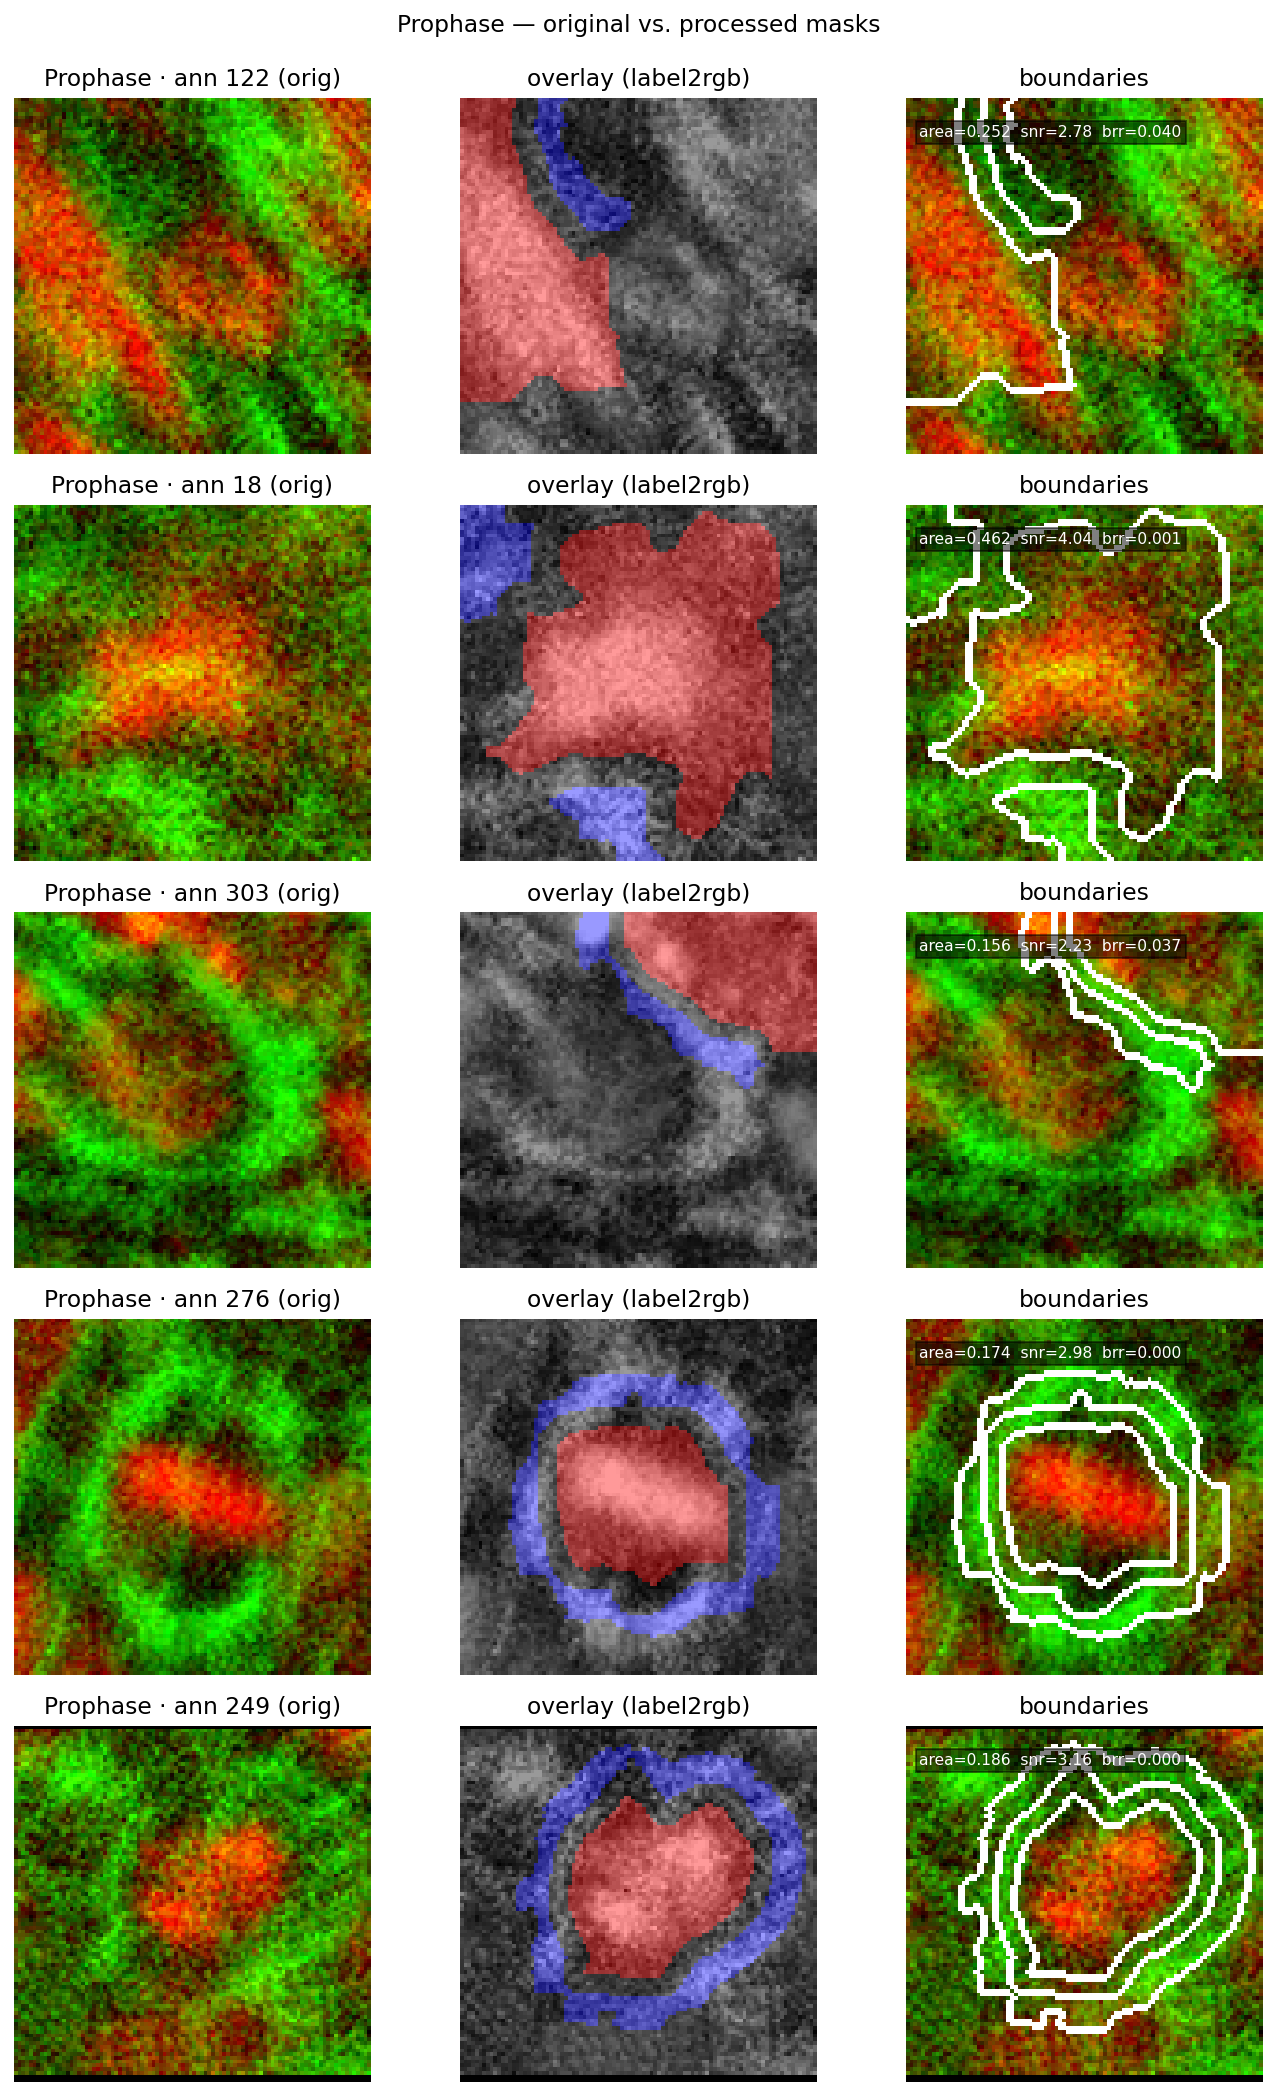

Saved: qc_previews/preview_Prophase.png


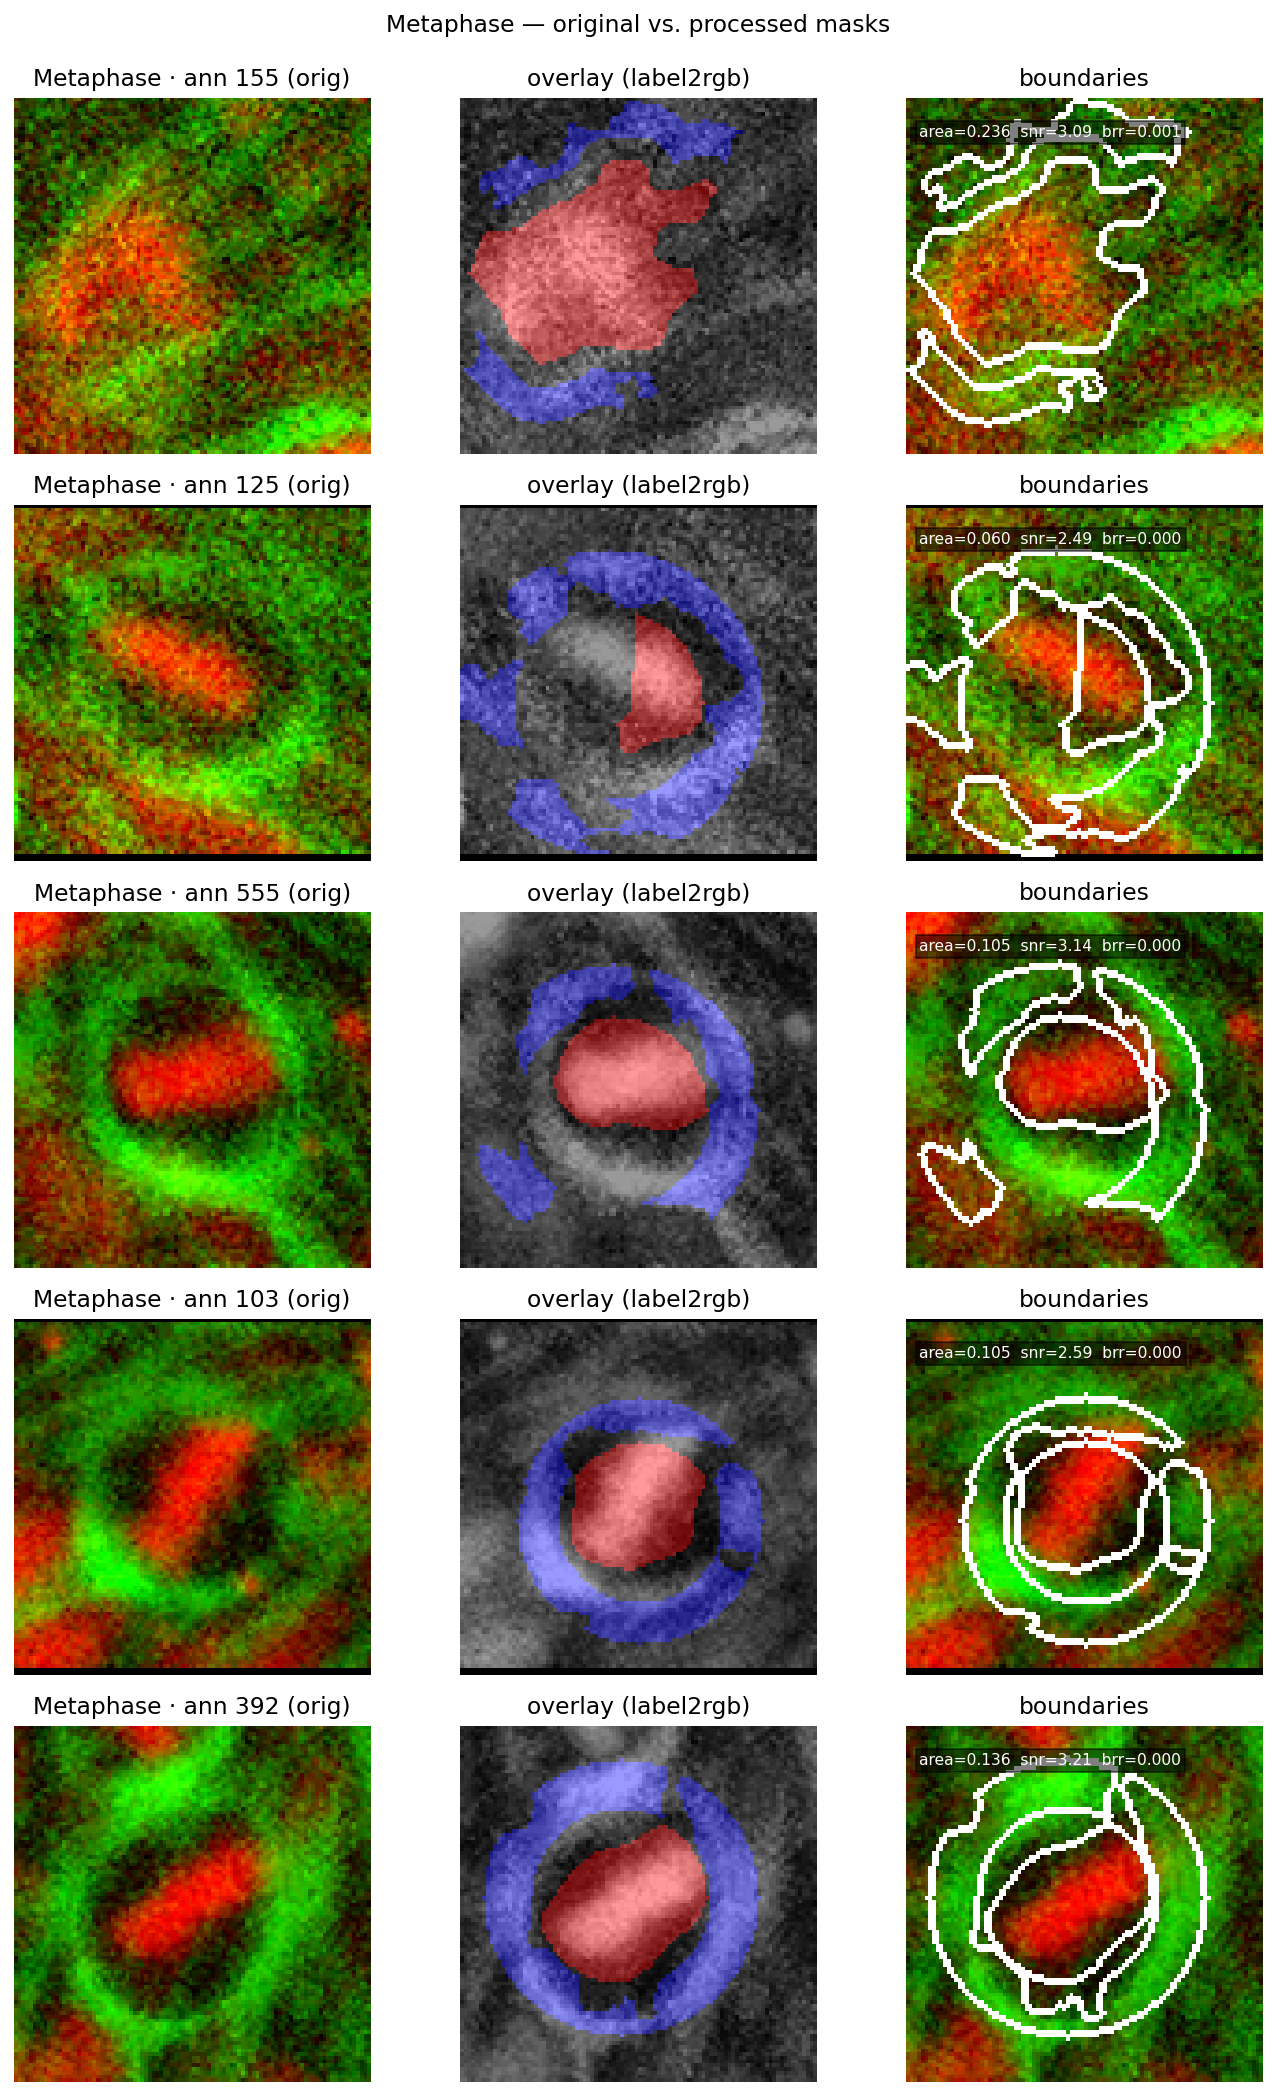

Saved: qc_previews/preview_Metaphase.png


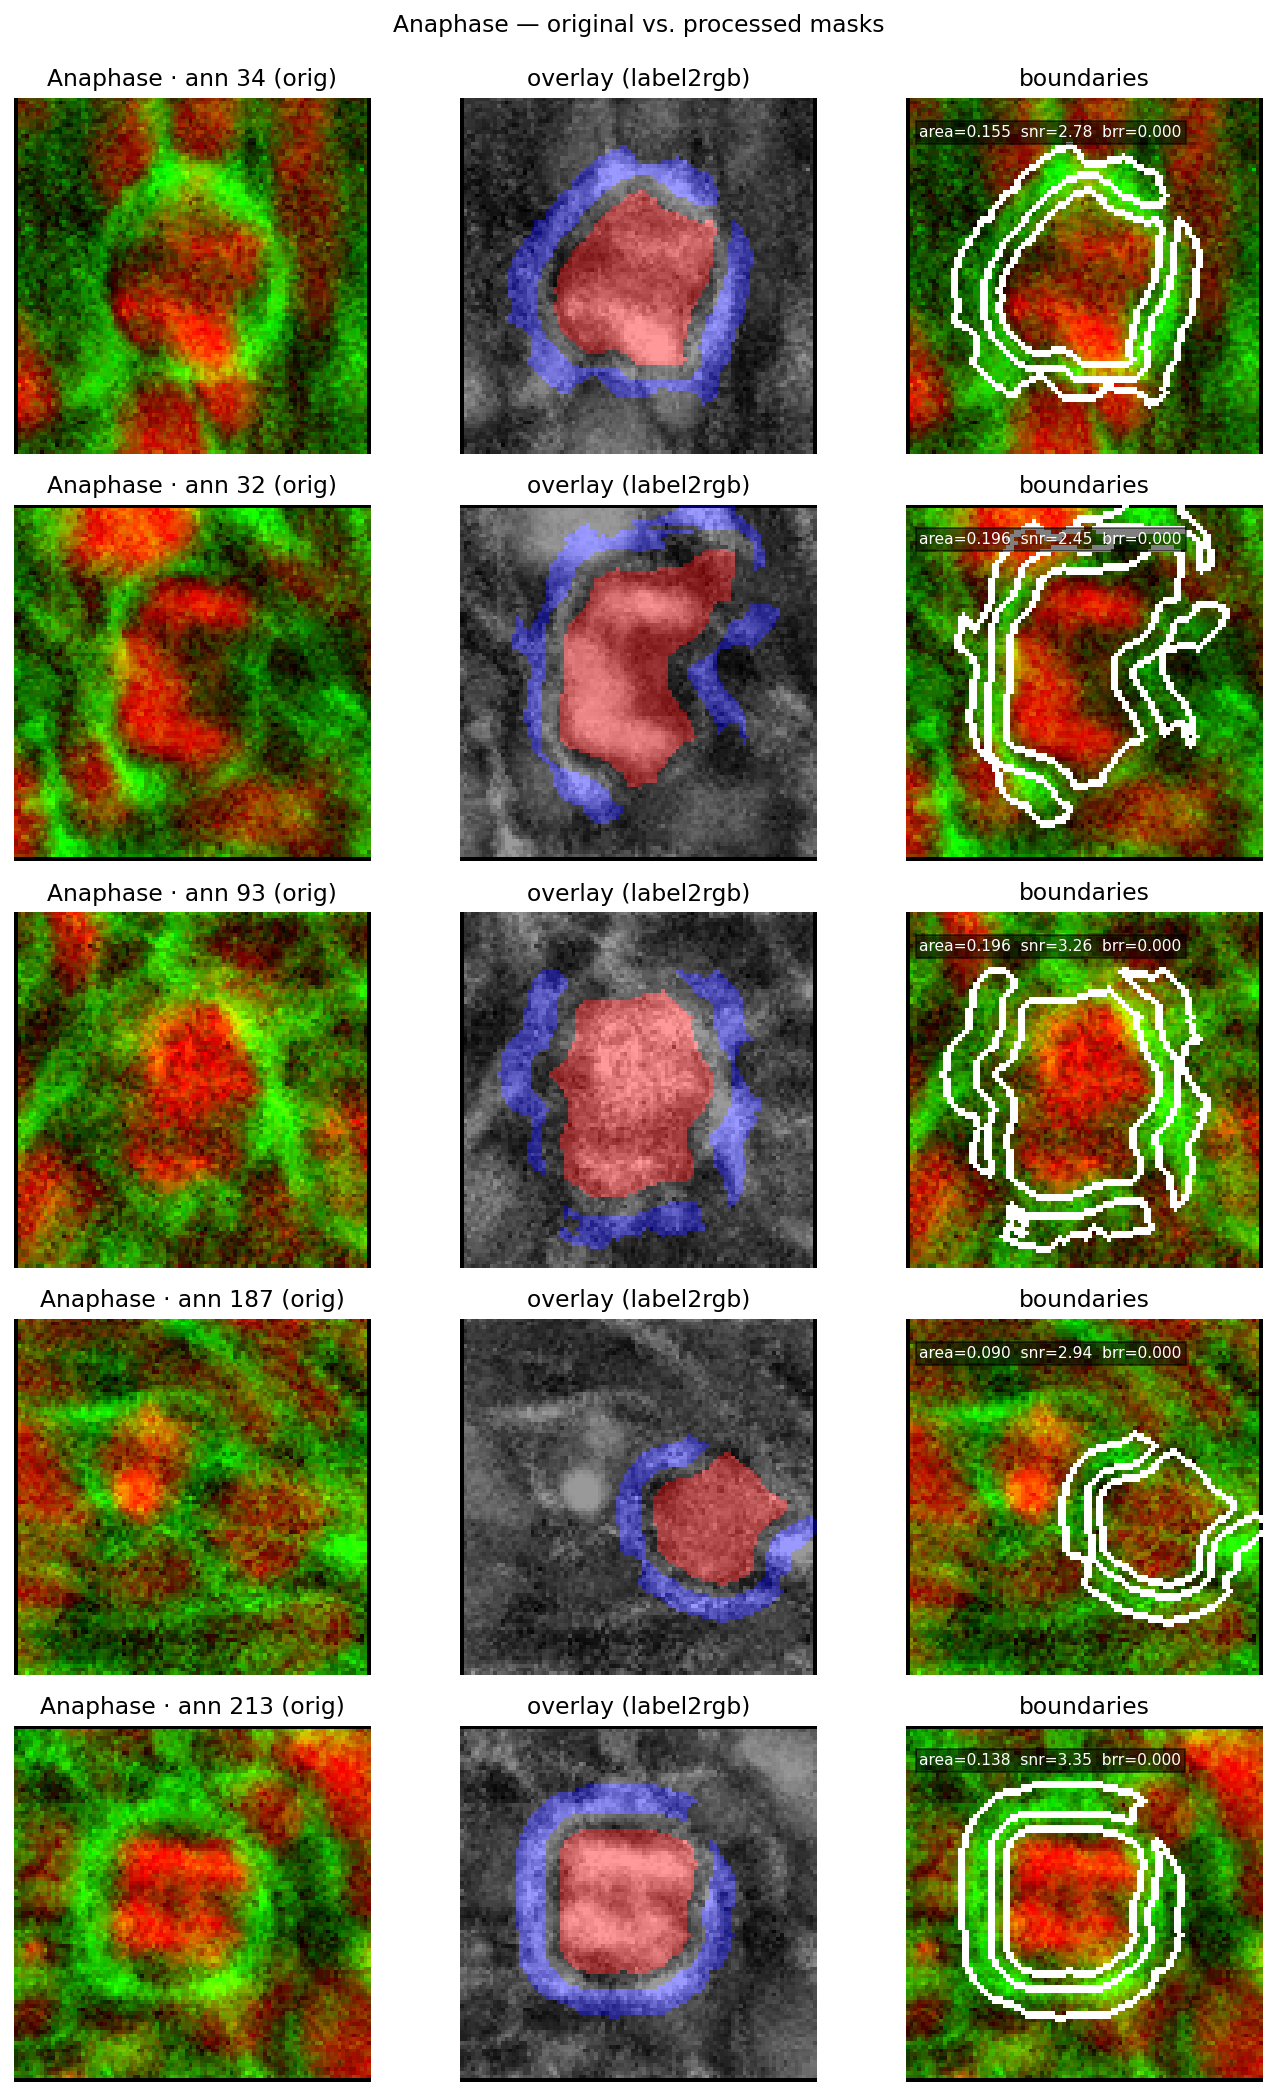

Saved: qc_previews/preview_Anaphase.png


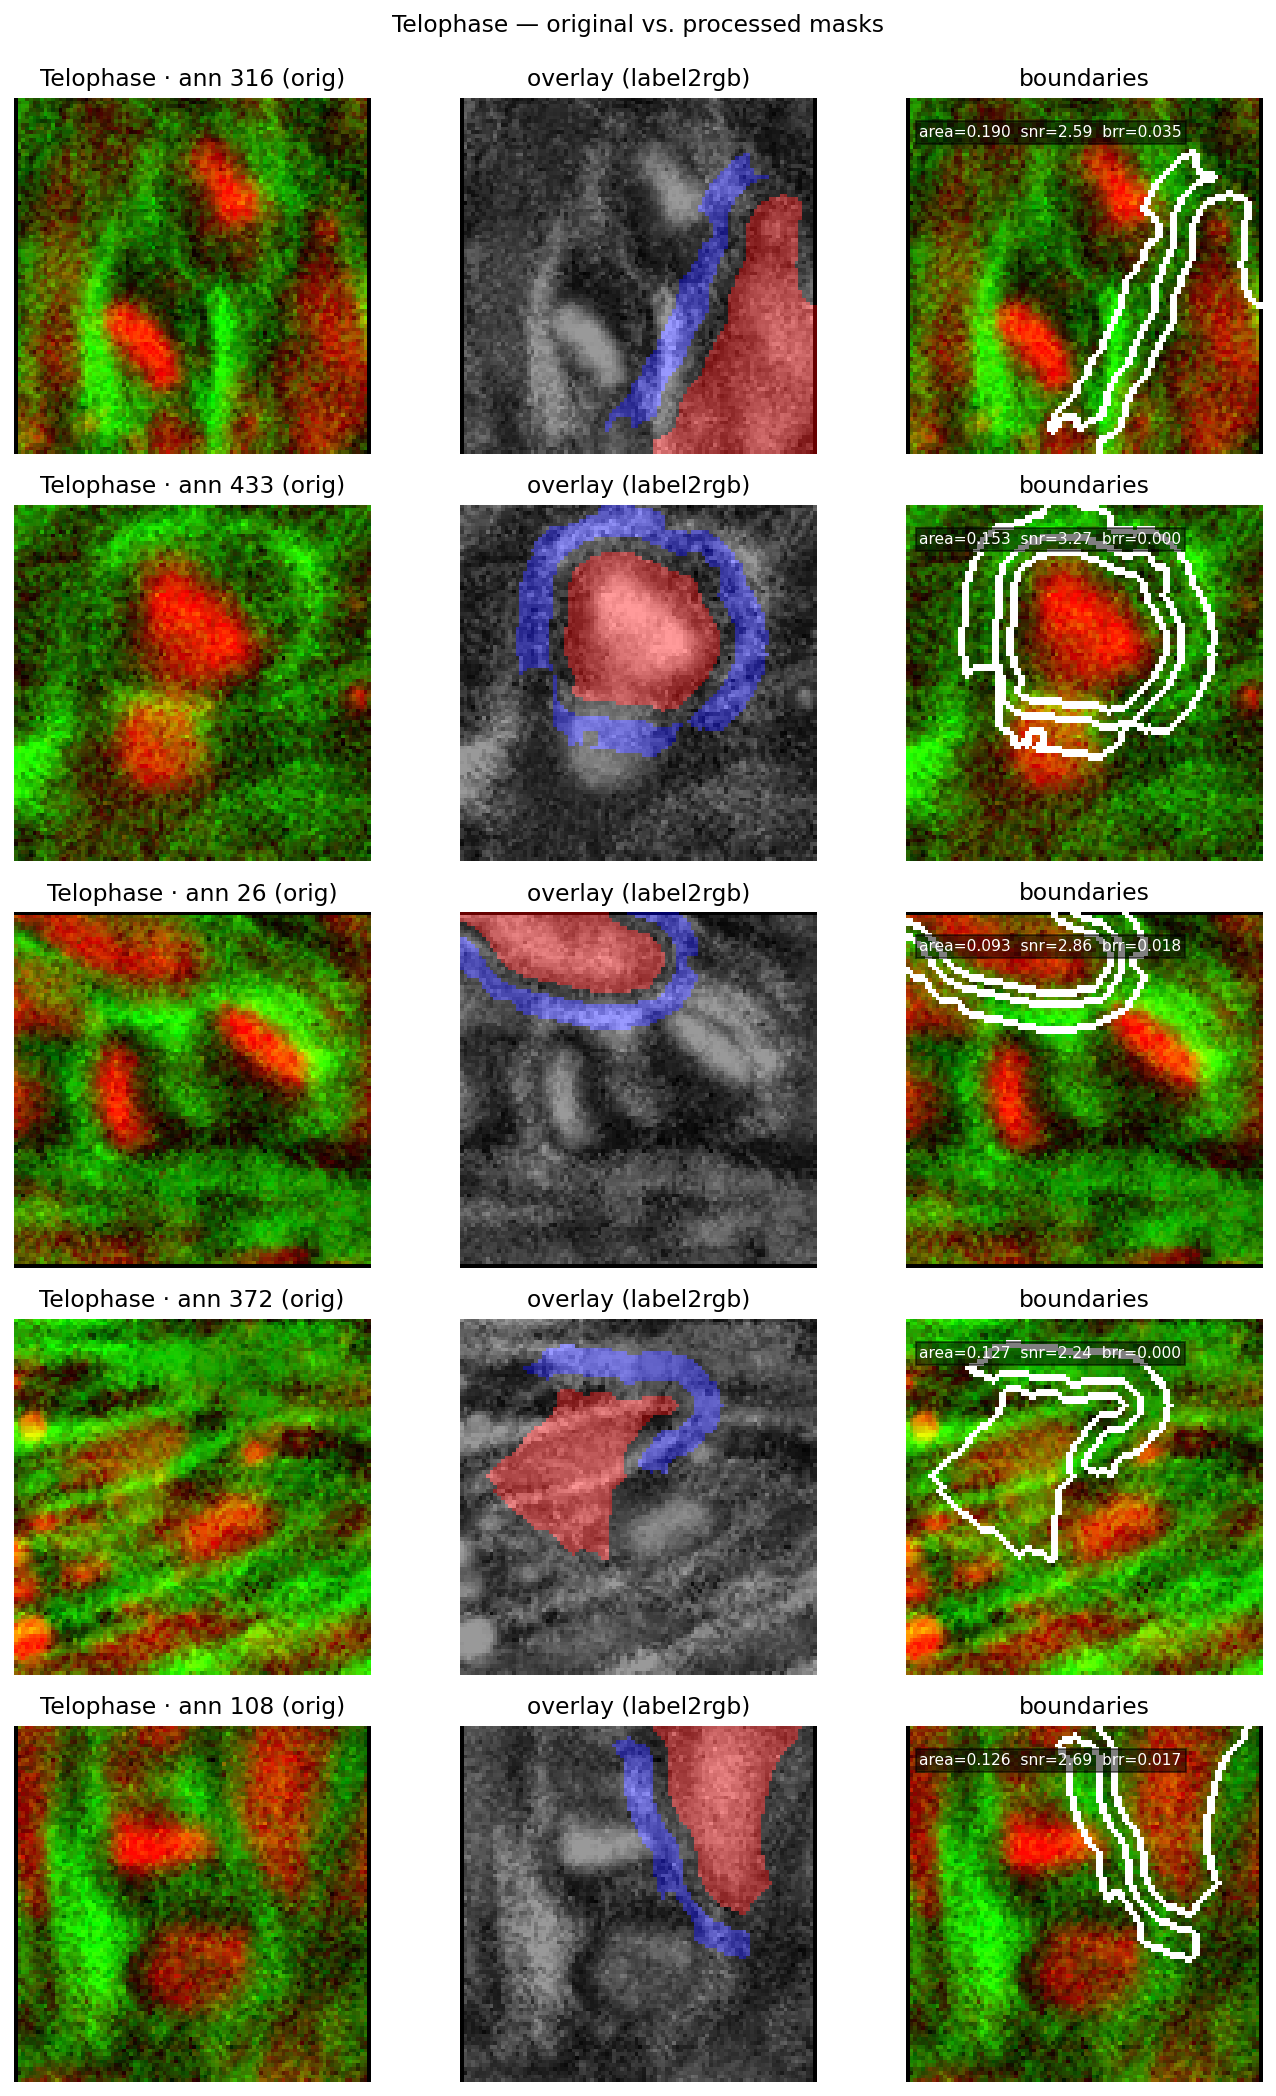

Saved: qc_previews/preview_Telophase.png


In [49]:
# %% Visual QC: show original patch + mask overlay + boundaries; save montages
import os, csv, random, math
from collections import defaultdict
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from skimage.segmentation import find_boundaries

MANIFEST_CSV = "kept_manifest.csv"
OUT_DIR = "qc_previews"
SAMPLES_PER_CLASS = 5   # tweak: how many rows per class to preview
RANDOM_SEED = 42        # tweak: set to None for different picks each run

os.makedirs(OUT_DIR, exist_ok=True)
if RANDOM_SEED is not None:
    random.seed(RANDOM_SEED)

# --- load manifest
rows = []
with open(MANIFEST_CSV, "r", newline="") as f:
    r = csv.DictReader(f)
    for row in r:
        rows.append(row)
if not rows:
    raise RuntimeError("kept_manifest.csv is empty or missing.")

# --- group by class
by_cls = defaultdict(list)
for row in rows:
    by_cls[row["_class"]].append(row)

def load_patch(path):
    return np.array(Image.open(path).convert("RGB"))

def load_masks_from_seg(seg_path):
    # seg is RGB where R = nucleus mask (255), G = cytoplasm mask (255)
    seg = np.array(Image.open(seg_path).convert("RGB"))
    nuc = seg[...,0] > 0
    cyt = seg[...,1] > 0
    return nuc, cyt

def make_overlay(rgb, nuc, cyt, alpha=0.40):
    # pack labels: 0=bg, 1=nucleus, 2=cytoplasm
    labels = np.zeros(rgb.shape[:2], dtype=np.int32)
    labels[nuc] = 1
    labels[cyt] = 2
    # blend labels over the original image
    ov = label2rgb(labels, image=rgb, alpha=alpha, bg_label=0, kind="overlay")
    return (np.clip(ov*255, 0, 255)).astype(np.uint8), labels

def draw_boundaries(rgb, labels):
    b = find_boundaries(labels, mode="thick", background=0).astype(bool)
    out = rgb.copy()
    out[b] = [255, 255, 255]  # white boundary
    return out

for cls, cls_rows in by_cls.items():
    picks = random.sample(cls_rows, min(SAMPLES_PER_CLASS, len(cls_rows)))
    n = len(picks)
    if n == 0:
        continue

    fig, axes = plt.subplots(n, 3, figsize=(10, 3*n), dpi=140)
    if n == 1:
        axes = np.array([axes])  # unify indexing

    for i, row in enumerate(picks):
        patch = load_patch(row["patch_path"])
        nuc, cyt = load_masks_from_seg(row["seg_path"])
        overlay, labels = make_overlay(patch, nuc, cyt, alpha=0.40)
        bimg = draw_boundaries(patch, labels)

        # left: original; middle: overlay; right: boundaries
        axes[i,0].imshow(patch);  axes[i,0].set_title(f"{cls} · ann {row['ann_id']} (orig)")
        axes[i,1].imshow(overlay);axes[i,1].set_title("overlay (label2rgb)")
        axes[i,2].imshow(bimg);   axes[i,2].set_title("boundaries")

        for j in range(3):
            axes[i,j].axis("off")

        # tiny caption with QC numbers if present
        try:
            area = float(row.get("area",""))
            snr  = float(row.get("snr",""))
            brr  = float(row.get("border_red",""))
            axes[i,2].text(
                3, 10, f"area={area:.3f}  snr={snr:.2f}  brr={brr:.3f}",
                fontsize=8, color="white", bbox=dict(facecolor="black", alpha=0.5, pad=2)
            )
        except Exception:
            pass

    fig.suptitle(f"{cls} — original vs. processed masks", y=0.995, fontsize=12)
    fig.tight_layout()
    out_path = os.path.join(OUT_DIR, f"preview_{cls}.png")
    fig.savefig(out_path, bbox_inches="tight")
    plt.show()
    print("Saved:", out_path)


## Difussion

In [2]:
# %% [markdown]
# ## 1) Imports & configuration
from dataclasses import dataclass
import os, sys, glob, csv, json, random
from typing import Optional, Dict, List, Tuple

import numpy as np
from PIL import Image

# Core scientific stack
from skimage.color import rgb2gray
from skimage.filters import sobel, threshold_otsu
from skimage.segmentation import watershed
from skimage.morphology import remove_small_holes, remove_small_objects
from skimage.measure import label
from skimage.metrics import structural_similarity as ssim
from scipy import ndimage as ndi

# Optional heavy deps — handled gracefully if missing
try:
    import torch
    TORCH_OK = True
except Exception:
    TORCH_OK = False

try:
    import lpips
    LPIPS_OK = True
except Exception:
    LPIPS_OK = False

try:
    import imagehash
    HASH_OK = True
except Exception:
    HASH_OK = False

if TORCH_OK:
    try:
        from diffusers import (
            StableDiffusionControlNetImg2ImgPipeline,
            ControlNetModel,
            EulerAncestralDiscreteScheduler,
        )
        DIFFUSERS_OK = True
    except Exception:
        DIFFUSERS_OK = False
else:
    DIFFUSERS_OK = False


@dataclass
class Cfg:
    # IO
    input_dir: str = "./data2ch"
    out_dir: str   = "./out_aug"

    # ControlNet choice
    control: str = "softedge"  # 'softedge' or 'scribble'
    base_model: str = "runwayml/stable-diffusion-v1-5"
    control_model_softedge: str = "lllyasviel/control_v11p_sd15_softedge"
    control_model_scribble: str = "lllyasviel/sd-controlnet-scribble"

    # Img2Img knobs (keep low to stay near original)
    strength: float = 0.20
    guidance_scale: float = 3.5
    steps: int = 20

    # Strategy for mapping back to 2-ch
    mode: str = "reuse_masks"  # 'reuse_masks' or 'resegment'

    # Gates
    min_area: float = 0.01
    min_snr: float  = 2.0
    min_ssim: float = 0.90
    max_lpips: float = 0.15

    # Dedup
    ahash_min_dist: int = 5

    # Misc
    num_aug_per_sample: int = 1
    save_rgb_preview: bool = True
    seed: int = 42

CFG = Cfg()
os.makedirs(CFG.out_dir, exist_ok=True)
os.makedirs(os.path.join(CFG.out_dir, "twoch"), exist_ok=True)
os.makedirs(os.path.join(CFG.out_dir, "rgb"), exist_ok=True)


In [3]:
# %% [markdown]
# ## 2) Utilities: IO, pseudo-RGB, control image, segmentation, QC & similarity

def ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)

def load_twoch_and_masks(path_ch1: str, path_ch2: str,
                         path_nucmask: Optional[str] = None,
                         path_cytmask: Optional[str] = None):
    ch1 = np.load(path_ch1).astype(np.float32)
    ch2 = np.load(path_ch2).astype(np.float32)
    nuc_mask, cyt_mask = None, None
    if path_nucmask and os.path.exists(path_nucmask):
        nuc_mask = (np.array(Image.open(path_nucmask).convert("L")) > 0).astype(np.uint8)
    if path_cytmask and os.path.exists(path_cytmask):
        cyt_mask = (np.array(Image.open(path_cytmask).convert("L")) > 0).astype(np.uint8)
    return ch1, ch2, nuc_mask, cyt_mask

def twoch_to_pseudorgb(ch1: np.ndarray, ch2: np.ndarray) -> np.ndarray:
    # R=nucleus, G=cytoplasm/body, B=0 — for visualization/img2img anchor
    rgb = np.stack([ch1, ch2, np.zeros_like(ch1)], axis=-1)
    rgb = np.clip(rgb, 0, 1)
    return (rgb * 255).astype(np.uint8)

def make_control_softedge(ch1: np.ndarray, ch2: np.ndarray) -> np.ndarray:
    # Edge-like control from a composite; ControlNet SoftEdge will refine
    comp = np.clip(0.7 * ch1 + 0.3 * ch2, 0, 1)
    edg = sobel(comp)
    edg = (edg - edg.min()) / (edg.ptp() + 1e-6)
    edge_rgb = np.stack([edg, edg, edg], axis=-1)
    return (edge_rgb * 255).astype(np.uint8)

def hysteresis_segmentation_ratio(rgb_u8: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # Re-segmentation via ratio R/(R+G) + hysteresis + cleanup
    rgb = rgb_u8.astype(np.float32) / 255.0
    R, G = rgb[...,0], rgb[...,1]
    ratio = (R + 1e-6) / (R + G + 1e-6)
    r = (ratio - ratio.min()) / (ratio.ptp() + 1e-6)

    try:
        t_hi = threshold_otsu(r)
    except ValueError:
        t_hi = r.mean()
    t_lo = 0.5 * t_hi

    strong = r >= t_hi
    weak   = (r >= t_lo) & ~strong

    # Weak pixels connected to strong via small dilation
    dil = ndi.binary_dilation(strong, structure=np.ones((3,3)), iterations=2)
    nucleus = strong | (weak & dil)
    nucleus = remove_small_objects(nucleus, min_size=8)
    nucleus = remove_small_holes(nucleus, area_threshold=16)

    # ring band around nucleus
    nuc_dil = ndi.binary_dilation(nucleus, iterations=2)
    cyt = (nuc_dil ^ nucleus).astype(np.uint8)
    return nucleus.astype(np.uint8), cyt

def map_rgb_back_to_twoch(aug_rgb_pil: Image.Image,
                          nuc_mask: Optional[np.ndarray],
                          cyt_mask: Optional[np.ndarray],
                          mode: str = "reuse_masks") -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    rgb = np.array(aug_rgb_pil).astype(np.float32) / 255.0
    R, G = rgb[...,0], rgb[...,1]
    ratio = (R + 1e-6) / (R + G + 1e-6)
    body  = rgb2gray(rgb)

    if mode == "resegment" or nuc_mask is None or cyt_mask is None:
        nuc_mask, cyt_mask = hysteresis_segmentation_ratio((rgb * 255).astype(np.uint8))

    ch1 = ratio * (nuc_mask > 0)
    ch2 = body  * (cyt_mask > 0)
    twoch = np.stack([np.clip(ch1, 0, 1), np.clip(ch2, 0, 1)], axis=-1).astype(np.float32)
    return twoch, nuc_mask.astype(np.uint8), cyt_mask.astype(np.uint8)

def qc_area_snr(x_twoch: np.ndarray, nuc_mask: np.ndarray) -> Tuple[float, float]:
    ch1 = x_twoch[...,0]
    area = float(nuc_mask.mean())
    inside  = ch1[nuc_mask > 0]
    outside = ch1[nuc_mask == 0]
    snr = float((inside.mean() + 1e-6) / (outside.std() + 1e-6)) if outside.std() > 0 else float("inf")
    return area, snr

def closeness(orig_rgb: Image.Image, aug_rgb: Image.Image, want_lpips: bool = True) -> Tuple[float, Optional[float]]:
    ssim_val = ssim(np.array(orig_rgb), np.array(aug_rgb), channel_axis=-1, data_range=255)
    lpips_val = None
    if want_lpips and LPIPS_OK and TORCH_OK:
        model = lpips.LPIPS(net='alex').to('cuda')
        with torch.no_grad():
            def to_t(img):
                t = torch.from_numpy(np.array(img)).permute(2,0,1)[None].float().to('cuda')/127.5 - 1
                return t
            lpips_val = float(model(to_t(orig_rgb), to_t(aug_rgb)).mean().item())
    return ssim_val, lpips_val

def ahash_distance(img1: Image.Image, img2: Image.Image) -> int:
    if not HASH_OK:
        return 999
    h1 = imagehash.average_hash(img1)
    h2 = imagehash.average_hash(img2)
    return int(h1 - h2)

def iter_samples(input_root: str):
    classes = sorted([d for d in os.listdir(input_root) if os.path.isdir(os.path.join(input_root, d))])
    for cls in classes:
        p = os.path.join(input_root, cls)
        for ch1_path in sorted(glob.glob(os.path.join(p, "*_ch1.npy"))):
            base = os.path.basename(ch1_path).replace("_ch1.npy", "")
            ch2_path = os.path.join(p, f"{base}_ch2.npy")
            if not os.path.exists(ch2_path):
                continue
            mn = os.path.join(p, f"{base}_nucmask.png")
            mc = os.path.join(p, f"{base}_cytmask.png")
            yield cls, base, {
                "ch1": ch1_path,
                "ch2": ch2_path,
                "nucmask": mn if os.path.exists(mn) else None,
                "cytmask": mc if os.path.exists(mc) else None,
            }


In [4]:

# %% [markdown]
# ## 3) Diffusion pipeline (Stable Diffusion + ControlNet, Img2Img)
# If CUDA/Diffusers are unavailable, returns None → pipeline falls back to no-op (copies inputs).

def init_diffusion_pipeline(cfg: Cfg):
    if not (TORCH_OK and DIFFUSERS_OK):
        print("[WARN] Torch/Diffusers not available. Diffusion will be skipped.")
        return None
    control_id = cfg.control_model_softedge if cfg.control == "softedge" else cfg.control_model_scribble
    controlnet = ControlNetModel.from_pretrained(control_id, torch_dtype=torch.float16)
    pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
        cfg.base_model, controlnet=controlnet, torch_dtype=torch.float16, safety_checker=None
    ).to("cuda")
    pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
    return pipe

def sd_img2img(pipe, init_rgb_u8: np.ndarray, control_rgb_u8: np.ndarray, cfg: Cfg, seed: int) -> Image.Image:
    if pipe is None:
        # no-op fallback so notebook still runs end-to-end
        return Image.fromarray(init_rgb_u8.copy())

    init_img = Image.fromarray(init_rgb_u8).resize((512, 512), Image.BICUBIC)
    ctrl_img = Image.fromarray(control_rgb_u8).resize((512, 512), Image.BICUBIC)
    out = pipe(
        prompt="fluorescence microscopy of single cell nucleus and cytoplasm, clean background, no text",
        negative_prompt="text, watermark, artifacts, extra cells, clutter",
        image=init_img,
        control_image=ctrl_img,
        strength=cfg.strength,
        guidance_scale=cfg.guidance_scale,
        num_inference_steps=cfg.steps,
        generator=torch.Generator(device="cuda").manual_seed(seed) if TORCH_OK else None,
    )
    aug_rgb = out.images[0].resize(init_img.size, Image.BICUBIC)
    # back to original patch size
    aug_rgb = aug_rgb.resize((init_rgb_u8.shape[1], init_rgb_u8.shape[0]), Image.BICUBIC)
    return aug_rgb


In [5]:
# %% [markdown]
# ## 4) End-to-end: one sample → many augmentations (with gates & dedup)

def augment_sample(pipe,
                   cls: str, base: str, paths: Dict[str, str],
                   cfg: Cfg,
                   prior_rgbs_for_class: List[Image.Image],
                   writer: csv.DictWriter):
    ch1, ch2, nm, cm = load_twoch_and_masks(paths["ch1"], paths["ch2"], paths["nucmask"], paths["cytmask"])
    orig_rgb_u8 = twoch_to_pseudorgb(ch1, ch2)
    control_u8  = make_control_softedge(ch1, ch2)
    orig_pil    = Image.fromarray(orig_rgb_u8)

    for k in range(cfg.num_aug_per_sample):
        # deterministic but unique seed per (base, k)
        seed_k = cfg.seed + hash((base, k)) % (2**31 - 1)
        aug_rgb_pil = sd_img2img(pipe, orig_rgb_u8, control_u8, cfg, seed=seed_k)

        # Map back to 2-ch
        twoch, nuc_mask, cyt_mask = map_rgb_back_to_twoch(aug_rgb_pil, nm, cm, mode=cfg.mode)

        # QC gates
        area, snr = qc_area_snr(twoch, nuc_mask)
        if area < cfg.min_area or snr < cfg.min_snr:
            print(f"[DROP][QC] {cls}/{base}#{k} area={area:.4f} snr={snr:.3f}")
            continue

        # Closeness gates
        ssim_val, lpips_val = closeness(orig_pil, aug_rgb_pil, want_lpips=True)
        if ssim_val < cfg.min_ssim:
            print(f"[DROP][SSIM] {cls}/{base}#{k} ssim={ssim_val:.3f} < {cfg.min_ssim}")
            continue
        if lpips_val is not None and lpips_val > cfg.max_lpips:
            print(f"[DROP][LPIPS] {cls}/{base}#{k} lpips={lpips_val:.3f} > {cfg.max_lpips}")
            continue

        # Dedup versus prior in this class
        is_dup = False
        if HASH_OK:
            for prior in prior_rgbs_for_class:
                dist = int(imagehash.average_hash(prior) - imagehash.average_hash(aug_rgb_pil))
                if dist < cfg.ahash_min_dist:
                    is_dup = True
                    print(f"[DROP][DUP] {cls}/{base}#{k} aHash dist {dist} < {cfg.ahash_min_dist}")
                    break
        if is_dup:
            continue

        # Save outputs + manifest
        out_base = f"{cls}__{base}__aug{k}"
        rgb_path = os.path.join(cfg.out_dir, "rgb",   f"{out_base}.png")
        ch1_path = os.path.join(cfg.out_dir, "twoch", f"{out_base}_ch1.npy")
        ch2_path = os.path.join(cfg.out_dir, "twoch", f"{out_base}_ch2.npy")

        if cfg.save_rgb_preview:
            aug_rgb_pil.save(rgb_path)
            prior_rgbs_for_class.append(aug_rgb_pil.copy())

        np.save(ch1_path, twoch[...,0])
        np.save(ch2_path, twoch[...,1])

        writer.writerow({
            "id": out_base, "class": cls, "src_id": base, "seed": seed_k,
            "ch1_path": ch1_path, "ch2_path": ch2_path,
            "rgb_path": rgb_path if cfg.save_rgb_preview else "",
            "ssim": f"{ssim_val:.4f}",
            "lpips": f"{lpips_val:.4f}" if lpips_val is not None else "",
            "ahash": "" if not HASH_OK else str(imagehash.average_hash(aug_rgb_pil)),
            "area": f"{area:.6f}", "snr": f"{snr:.6f}",
            "mode": cfg.mode, "control": cfg.control,
            "strength": cfg.strength, "cfg": cfg.guidance_scale, "steps": cfg.steps,
        })


In [6]:
# %% [markdown]
# ## 5) Run over a dataset (build manifest)
manifest_path = os.path.join(CFG.out_dir, "aug_manifest.csv")
need_header = not os.path.exists(manifest_path)
mf = open(manifest_path, "a", newline="")
writer = csv.DictWriter(mf, fieldnames=[
    "id","class","src_id","seed",
    "ch1_path","ch2_path","rgb_path",
    "ssim","lpips","ahash","area","snr",
    "mode","control","strength","cfg","steps"
])
if need_header: writer.writeheader()

# Init diffusion (may be None if torch/diffusers unavailable)
pipe = init_diffusion_pipeline(CFG)

# Per-class cache for dedup rgb previews
prior_rgb_by_class: Dict[str, List[Image.Image]] = {}

random.seed(CFG.seed); np.random.seed(CFG.seed)

for cls, base, paths in iter_samples(CFG.input_dir):
    if cls not in prior_rgb_by_class:
        prior_rgb_by_class[cls] = []
    augment_sample(pipe, cls, base, paths, CFG, prior_rgb_by_class[cls], writer)

mf.flush(); mf.close()
print("[DONE] Wrote:", manifest_path)
print("Two-channel outputs →", os.path.join(CFG.out_dir, "twoch"))
print("RGB previews       →", os.path.join(CFG.out_dir, "rgb"))


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /lllyasviel/control_v11p_sd15_softedge/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7efbfad8f5e0>: Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: 9b0135bf-cd12-40ef-bd09-636fe3e2a330)')' thrown while requesting HEAD https://huggingface.co/lllyasviel/control_v11p_sd15_softedge/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /lllyasviel/control_v11p_sd15_softedge/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7efbfad8ca00>: Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: bc77e259-76cb-4ca8-91e3-fa5de1185af8)')' thrown while requesting HEAD https:

KeyboardInterrupt: 

In [ ]:
# %% [markdown]
# ## 6) (Optional) Make a tiny toy dataset to sanity-check the pipeline
# Run this once if you don't have data yet. It creates one class with a simple square nucleus.
import shutil, pathlib
root = Path = pathlib.Path

toy = root("data2ch") / "Cell"
toy.mkdir(parents=True, exist_ok=True)

# Simple 96x96 two-channel toy
ch1 = np.zeros((96,96), np.float32); ch2 = np.zeros_like(ch1)
ch1[30:60,30:60] = 0.9    # bright nucleus
ch2[25:65,25:65] = 0.4    # surrounding body
np.save(toy/"sample001_ch1.npy", ch1)
np.save(toy/"sample001_ch2.npy", ch2)

print("Toy data written to:", toy)
print("Re-run cells 5 to process it, or set CFG.input_dir='data2ch' above and run cell 5.")


In [ ]:
# %% [markdown]
# ## 7) Knobs worth trying
# - CFG.strength: 0.15–0.30 (keep low to stay near original)
# - CFG.guidance_scale: 2–5 (lower resists hallucination)
# - CFG.steps: 15–30 (or an LCM scheduler if you have it)
# - Switch CFG.mode to "resegment" for mild morphology variation
# - Tighten/relax gates: min_ssim (↑ stricter), max_lpips (↓ stricter)
#
# After you adjust, just re-run cells 3 → 5.
